In [1]:
# basic (built-in) Python packages
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt

# advanced (built-in) Python packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize

# my implemented Python functions and classes
from data.generate_data import generate_data
from model.BaseModel import BaseModel
from model.MLE import MLE
from model.OS import OS
from model.ORACLE import ORACLE
from model.Initial import Initial

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Hyperparameters

In [2]:
seed = 1
np.random.seed(seed=seed)

N = 100000        # the size of the unlabeled dataset
n = 5000            # pilot sample size
alpha = 1 # n**(-0.1)  
print(f"alpha={alpha:.4f}")

p = 10          # feature dimension
K = 2           # (K+1) classes
M = int(n / np.log(n))          # the size of the annotator pool
print(f"[n*alpha={int(n*alpha)}/N={N}]")
print(f"[M={M}] vs [n*alpha={int(n*alpha)}]")

alpha=1.0000
[n*alpha=5000/N=100000]
[M=587] vs [n*alpha=5000]


# Data Generation

In [3]:
beta, sigma_list, theta, X, Y, X1, X2, Y1, Y2, A1, AY1 = generate_data(K, p, N, n, M, alpha, seed=0)

True Labels 1    39315
0    33292
2    27393
dtype: int64 



In [4]:
sigma_list

array([0.1       , 0.10511073, 0.11022147, 0.1153322 , 0.12044293,
       0.12555366, 0.1306644 , 0.13577513, 0.14088586, 0.14599659,
       0.15110733, 0.15621806, 0.16132879, 0.16643952, 0.17155026,
       0.17666099, 0.18177172, 0.18688245, 0.19199319, 0.19710392,
       0.20221465, 0.20732538, 0.21243612, 0.21754685, 0.22265758,
       0.22776831, 0.23287905, 0.23798978, 0.24310051, 0.24821124,
       0.25332198, 0.25843271, 0.26354344, 0.26865417, 0.27376491,
       0.27887564, 0.28398637, 0.2890971 , 0.29420784, 0.29931857,
       0.3044293 , 0.30954003, 0.31465077, 0.3197615 , 0.32487223,
       0.32998296, 0.3350937 , 0.34020443, 0.34531516, 0.35042589,
       0.35553663, 0.36064736, 0.36575809, 0.37086882, 0.37597956,
       0.38109029, 0.38620102, 0.39131175, 0.39642249, 0.40153322,
       0.40664395, 0.41175468, 0.41686542, 0.42197615, 0.42708688,
       0.43219761, 0.43730835, 0.44241908, 0.44752981, 0.45264055,
       0.45775128, 0.46286201, 0.46797274, 0.47308348, 0.47819

# Initial Estimator

In [5]:
init_model = Initial(X1, AY1, A1, K)
init_beta, init_sigma, init_betams = init_model.init_param()
print(norm(init_beta - beta[1:]), norm(init_sigma - sigma_list))

0.007064082839608573 2.7226237298669465


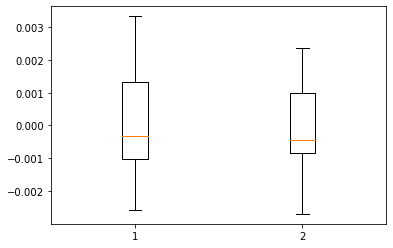

In [6]:
diff_mom, diff_son = init_model.check(init_beta, init_sigma, beta[1:], sigma_list)
plt.boxplot([diff_mom, diff_son.ravel()])
plt.show()

# Oracle

In [7]:
oracle_model = ORACLE(X1, AY1, A1, K, init_beta, sigma_list)
oracle_beta = oracle_model.update_alg(max_steps=5, tol=1e-5, true_beta=beta[1:])
print(norm(oracle_beta - beta[1:].ravel()))

######## [Step 1] ########
norm(gradient): 2.2361060
RMSE(beta): 0.0035080
######## [Step 2] ########
norm(gradient): 0.0058437
RMSE(beta): 0.0035044
######## [Step 3] ########
norm(gradient): 0.0000001
RMSE(beta): 0.0035044
0.003205074886370248


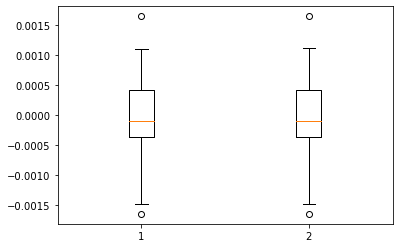

In [8]:
diff_mom, diff_son = oracle_model.check(beta[1:], sigma_list)
plt.boxplot([diff_mom, diff_son.ravel()])
plt.show()

In [9]:
print(norm(oracle_beta - beta[1:].ravel()))

0.003205074886370248


# One Step Update

In [10]:
os_model = OS(X1, AY1, A1, K, init_beta, init_sigma)
os_beta, os_sigma = os_model.update_alg(max_steps=1, tol=1e-5, true_beta=beta[1:].ravel())

######## [Step 1] ########
norm(gradient): 2.6432527
RMSE(beta): 0.0037241


In [11]:
ts_model = OS(X1, AY1, A1, K, init_beta, init_sigma)
ts_beta, ts_sigma = ts_model.update_alg(max_steps=2, tol=1e-5, true_beta=beta[1:].ravel())

######## [Step 1] ########
norm(gradient): 2.6432527
RMSE(beta): 0.0037241
######## [Step 2] ########
norm(gradient): 0.2981752
RMSE(beta): 0.0030604


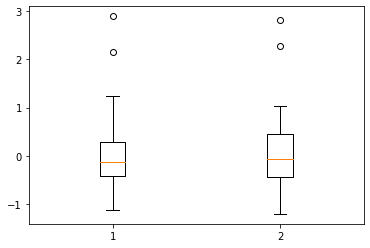

In [12]:
diff_mom, diff_son, var = os_model.check(init_beta, init_sigma, beta[1:], sigma_list)
plt.boxplot([diff_mom.ravel(), diff_son.ravel()])
plt.show()

# MLE

In [13]:
mle_model = OS(X1, AY1, A1, K, init_beta, init_sigma)
# mle_beta, mle_sigma = mle_model.NR_alg(max_updates=3, max_steps=5, tol=1e-5, sig=0.1, lbd=0.1, rho=2, 
#                                         true_beta=beta[1:].ravel())
mle_beta, mle_sigma = mle_model.update_alg(max_steps=20, tol=1e-5, true_beta=beta[1:].ravel())

######## [Step 1] ########
norm(gradient): 2.6432527
RMSE(beta): 0.0037241
######## [Step 2] ########
norm(gradient): 0.2981752
RMSE(beta): 0.0030604
######## [Step 3] ########
norm(gradient): 0.0733066
RMSE(beta): 0.0030135
######## [Step 4] ########
norm(gradient): 0.0130404
RMSE(beta): 0.0029984
######## [Step 5] ########
norm(gradient): 0.0044986
RMSE(beta): 0.0029970
######## [Step 6] ########
norm(gradient): 0.0004877
RMSE(beta): 0.0029964
######## [Step 7] ########
norm(gradient): 0.0001655
RMSE(beta): 0.0029964
######## [Step 8] ########
norm(gradient): 0.0000175
RMSE(beta): 0.0029963


In [14]:
print(norm(mle_beta - beta[1:].ravel()), norm(mle_sigma - sigma_list))

0.0029963479976241277 2.1513630671076354
0.0029963479976241277 2.1513630671076354


# Compare

In [15]:
def compute_rmse(est, true):
    est = est.ravel()
    true = true.ravel()
    return norm(est - true)

In [16]:
B = 100
RMSE_results = []
NAME_results = []

In [ ]:
for seed in range(B):
    RMSE_list = [seed, n, alpha, M]
    NAME_list = ["seed", "n", "alpha", "M"]
    np.random.seed(seed)
    beta, sigma_list, theta, X, Y, X1, X2, Y1, Y2, A1, AY1 = generate_data(K, p, N, n, M, alpha, seed=seed)

    # Initial Estimator
    print(f"\n########## Initial Estimator ##########")
    init_model = Initial(X1, AY1, A1, K)
    init_beta, init_sigma, init_betams = init_model.init_param()
    init_beta_rmse = compute_rmse(init_beta, beta[1:])
    init_sigma_rmse = compute_rmse(init_sigma, sigma_list)
    print(init_beta_rmse, init_sigma_rmse)
    RMSE_list += [init_beta_rmse, init_sigma_rmse]
    NAME_list += ["init_beta", "init_sigma"]
    
    # OS (One-Step) Estimator 
    print(f"\n########## OS Estimator ##########")
    os_model = OS(X1, AY1, A1, K, init_beta, init_sigma)
    os_beta, os_sigma = os_model.update_alg(max_steps=1, tol=1e-5, true_beta=beta[1:].ravel())
    os_beta_rmse = compute_rmse(os_beta, beta[1:])
    os_sigma_rmse = compute_rmse(os_sigma, sigma_list)
    print(os_beta_rmse, os_sigma_rmse)
    RMSE_list += [os_beta_rmse, os_sigma_rmse]
    NAME_list += ["os_beta", "os_sigma"]

    # TS
    print(f"\n########## MLE(NR) Estimator ##########")
    ts_model = OS(X1, AY1, A1, K, init_beta, init_sigma)
    ts_beta, ts_sigma = ts_model.update_alg(max_steps=2, tol=1e-5, true_beta=beta[1:].ravel())
    ts_beta_rmse = compute_rmse(ts_beta, beta[1:])
    ts_sigma_rmse = compute_rmse(ts_sigma, sigma_list)
    print(ts_beta_rmse, ts_sigma_rmse)
    RMSE_list += [ts_beta_rmse, ts_sigma_rmse]
    NAME_list += ["ts_beta", "ts_sigma"]
    
    # Oracle
    print(f"\n########## ORACLE Estimator ##########")
    oracle_model = ORACLE(X1, AY1, A1, K, init_beta, sigma_list)
    oracle_beta = oracle_model.update_alg(max_steps=5, tol=1e-5, true_beta=beta[1:])
    oracle_beta_rmse = compute_rmse(oracle_beta, beta[1:])
    print(oracle_beta_rmse)
    RMSE_list.append(oracle_beta_rmse)
    NAME_list.append("oracle_beta")

    # Record Results
    RMSE_results.append(RMSE_list)
    a = pd.DataFrame(RMSE_results, columns=NAME_list)
    a.to_csv(f"/Users/helenology/Desktop/[M={M}]rmse_data.csv")

True Labels 1    39315
0    33292
2    27393
dtype: int64 


########## Initial Estimator ##########
0.007064082839608573 2.7226237298669465

########## OS Estimator ##########
######## [Step 1] ########
norm(gradient): 2.6432527
RMSE(beta): 0.0037241
0.0037241466021607638 2.104895337757084

########## MLE(NR) Estimator ##########
######## [Step 1] ########
norm(gradient): 2.6432527
RMSE(beta): 0.0037241
######## [Step 2] ########
norm(gradient): 0.2981752
RMSE(beta): 0.0030604
0.003060353628394385 2.147726352313345

########## ORACLE Estimator ##########
######## [Step 1] ########
norm(gradient): 2.2361060
RMSE(beta): 0.0035080
######## [Step 2] ########
norm(gradient): 0.0058437
RMSE(beta): 0.0035044
######## [Step 3] ########
norm(gradient): 0.0000001
RMSE(beta): 0.0035044
0.003205074886370248
True Labels 1    51747
2    24464
0    23789
dtype: int64 


########## Initial Estimator ##########
0.00539451464800366 2.2306008906175983

########## OS Estimator ##########
######## [Step 1